<a href="https://colab.research.google.com/github/sheramir/MIT-DS/blob/main/High_Code_SVHN_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Project: Street View Housing Number Digit Recognition**

# **Marks: 60**

--------------
## **Context**
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents.

----------------
## **Objective**
----------------

Our objective is to predict the number depicted inside the image by using Artificial or Fully Connected Feed Forward Neural Networks and Convolutional Neural Networks. We will go through various models of each and finally select the one that is giving us the best performance.

-------------
## **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**

Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing the necessary libraries**

In [3]:
import numpy as np

# A libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning libraries
import tensorflow as tf

import keras

from tensorflow.keras.models import Sequential

# Importing all the different layers and optimizers
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.utils import to_categorical

# prediction test reports
from sklearn.metrics import classification_report, confusion_matrix


**Let us check the version of tensorflow.**

In [4]:
print("Tenserflow version:" ,tf.__version__)

Tenserflow version: 2.18.0


## **Load the dataset**

- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.

In [5]:
import h5py

file_path = '/content/drive/MyDrive/ADSP/Elective_Project/SVHN_single_grey1.h5'

# Check the structure of the hdf5 file
f =  h5py.File(file_path, 'r')
print(f.keys())
f.close()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>


In [108]:
# Load the data into (X_train, y_train, X_test, y_test, X_val, y_val)

try:
    with h5py.File(file_path, 'r') as hf:
        # Access the data within the .h5 file
        # Example: Assuming your data is stored under keys 'X_train', 'y_train', etc.
        X_train = hf['X_train'][:]
        y_train = hf['y_train'][:]
        X_test = hf['X_test'][:]
        y_test = hf['y_test'][:]

        print("Data loaded successfully!")

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except KeyError as e:
    print(f"Error: Key not found in the .h5 file: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Data loaded successfully!


Check the number of images in the training and the testing dataset.

In [7]:
# Show number of images in each dataset
print("Number of images in X_train:", X_train.shape[0])
print("Number of images in X_test:", X_test.shape[0])

Number of images in X_train: 42000
Number of images in X_test: 18000


In [8]:
# Show size of image
print("Images size: ",X_train.shape[1] , "X", X_train.shape[2])

Images size:  32 X 32


**Observation:**

The dataset contain 2 datasets: train and test.

* Train dataset has 42,000 images
* Test dataset has 18,000 images


The images size is 32 X 32 (greyscale).

The .h5 file contains also a Val dataset but it is actually the train and test datasets combined before a split, so I won't use it.

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

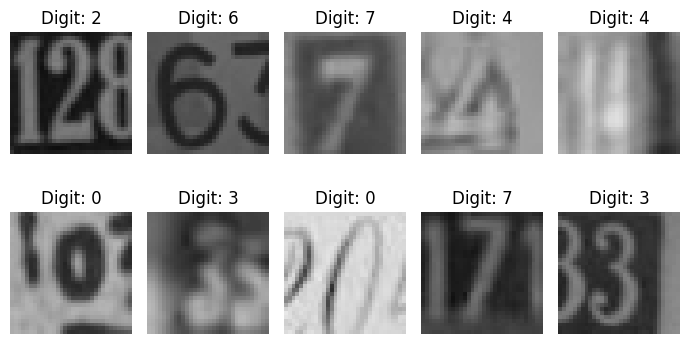

In [109]:
# Showing first 10 images and corresponding labels

cols = 5
rows = 2

fig = plt.figure(figsize = (7, 4))

for i in range(cols):

    for j in range(rows):

        indx = i * rows + j

        ax = fig.add_subplot(rows, cols, indx + 1)

        ax.imshow(X_train[indx, :], cmap='gray', vmin=0, vmax=255)

        ax.set_title(f"Digit: {y_train[indx]}")

        ax.axis('off')

plt.tight_layout()
plt.show()


## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [10]:
print("Shape of image:", X_train[0].shape)
print("\nArray of pixels for the first image:\n", X_train[0])

Shape of image: (32, 32)

Array of pixels for the first image:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


### **Normalize the train and the test data**

In [11]:
# Normalizing the image pixels
# Make sure the normalization occurs only once

if X_train.max() > 1:
  X_train = X_train / 255.0
if X_test.max() > 1:
  X_test = X_test / 255.0

print("Shape of first image:", X_train[0].shape)
print("\nArray of pixels for the first image:\n", X_train[0])

Shape of first image: (32, 32)

Array of pixels for the first image:
 [[0.12968785 0.11866706 0.10530196 ... 0.2801847  0.2283153  0.16860352]
 [0.09893451 0.10020902 0.1175549  ... 0.4432192  0.40534863 0.33056822]
 [0.10304902 0.08868118 0.15873058 ... 0.44432473 0.47754902 0.45263842]
 ...
 [0.11196157 0.14200786 0.17678471 ... 0.09465059 0.09840274 0.10219726]
 [0.15072627 0.10381687 0.09126157 ... 0.11023294 0.11556196 0.11790627]
 [0.19724864 0.10226392 0.0942702  ... 0.19477727 0.19942354 0.20799099]]


Print the shapes of Training and Test data

In [12]:
print("X_train:",X_train.shape, "y_train:",y_train.shape)
print("X_test:",X_test.shape, "y_test:",y_test.shape)

X_train: (42000, 32, 32) y_train: (42000,)
X_test: (18000, 32, 32) y_test: (18000,)


### Flatten the images

In [13]:
# The first models use 1D array as input.
# So we need to reshape the 2D images datasets to flat 1D.

X_train = X_train.reshape(X_train.shape[0], 1024)

X_test = X_test.reshape(X_test.shape[0], 1024)

In [14]:
print("X_train:",X_train.shape, "y_train:",y_train.shape)
print("X_test:",X_test.shape, "y_test:",y_test.shape)

X_train: (42000, 1024) y_train: (42000,)
X_test: (18000, 1024) y_test: (18000,)


### **One-hot encode output**

In [15]:
# Convert y_train and y_test to one-hot only if it was not already converted

if (y_train.ndim == 1):
    y_train = to_categorical(y_train)

if (y_test.ndim == 1):
    y_test = to_categorical(y_test)

In [16]:
print("X_train:",X_train.shape, "y_train:",y_train.shape)
print("X_test:",X_test.shape, "y_test:",y_test.shape)

X_train: (42000, 1024) y_train: (42000, 10)
X_test: (18000, 1024) y_test: (18000, 10)


In [17]:
# Show one-hot encoded values
for i in range(3):
  print (f"y_train[{i}] = ",y_train[i])
for i in range(3):
  print (f"y_test[{i}] = ",y_test[i])

y_train[0] =  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
y_train[1] =  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
y_train[2] =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
y_test[0] =  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
y_test[1] =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
y_test[2] =  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


**Observation:**

* Input images data 2D dimensions (32x32) was reshaped to 1D (1024)
* Input data was normalized
* Output y was converted to 1-hot with 10 categories


## **Model Building**

Now that we have done the data preprocessing, let's build an ANN model.

### Fix the seed for random number generators

In [18]:
# Ensuring reproducibility in the executions
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **64 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **32 nodes and the relu activation**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_1 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train an ANN model as per the above mentioned architecture.**

In [19]:
# Building the first ANN model:
# The model is a simple fully connected (dense) network with 2 hidden layers
# and one 10-outputs layer with softmax activation.

def nn_model_1():
    model = Sequential() # Initialized a sequential model
    model.add(Input(shape=(1024,)))  # Input of flatten image
    model.add(Dense(64, activation='relu')) # First hidden layer
    model.add(Dense(32, activation='relu')) # Second hidden layer
    model.add(Dense(10, activation='softmax'))  # Classification output

    # Compile the model for categorical classification
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

# Create an instance of the model
model_1 = nn_model_1()


In [20]:
# Printing the model summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,010 (265.66 KB)

 Trainable params: 68,010 (265.66 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
history_1 = model_1.fit(X_train, y_train,
                      validation_split=0.2,
                      batch_size=128,
                      verbose=1,
                      epochs=20)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1073 - loss: 2.3092 - val_accuracy: 0.1632 - val_loss: 2.2677
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1778 - loss: 2.2184 - val_accuracy: 0.2912 - val_loss: 2.0361
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3392 - loss: 1.9184 - val_accuracy: 0.4385 - val_loss: 1.6545
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4624 - loss: 1.6101 - val_accuracy: 0.5181 - val_loss: 1.4750
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5248 - loss: 1.4636 - val_accuracy: 0.5379 - val_loss: 1.4121
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5540 - loss: 1.3859 - val_accuracy: 0.5629 - val_loss: 1.3575
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5754 - loss: 1.3312 - val_accuracy: 0.5846 - val_loss: 1.3061
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5941 - loss: 1.2863 - val_accuracy: 0

### **Plot the Training and Validation Accuracies and write down your Observations.**

In [22]:
# Define a function to plot model accuracy and print test accuracy.
# This function will be re-used on all the models in the notebook

def plot_accuracy_loss(history, nn_model, xtest, ytest):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Calculate loss and accuracy on text dataset
    test_loss, test_acc = nn_model.evaluate(xtest, ytest)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

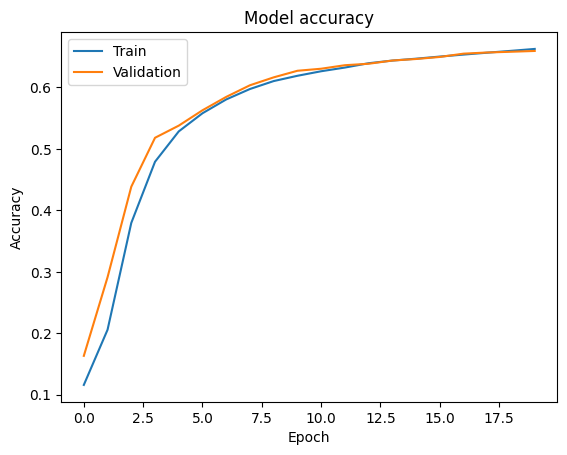

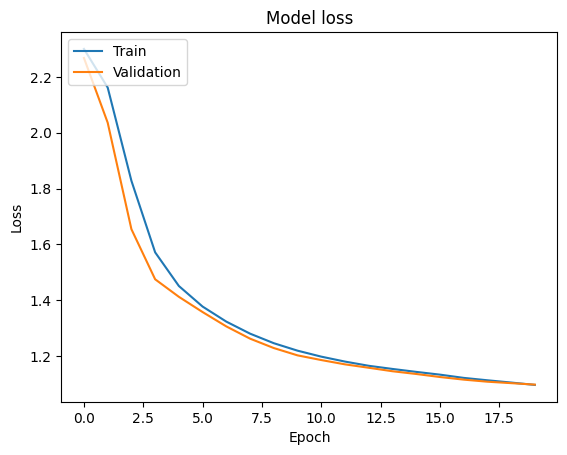

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6725 - loss: 1.0668
Test Accuracy: 0.6675
Test Loss: 1.0909


In [23]:
plot_accuracy_loss(history_1, model_1, X_test, y_test)

**Observations:**

* Val_accuracy: 0.6594,  Val_loss: 1.0976
* Test accuracy: 0.6675,  Test loss: 1.0909
* These are not very good results

Let's build one more model with higher complexity and see if we can improve the performance of the model.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [24]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators

import random

np.random.seed(42)

random.seed(42)

tf.random.set_seed(42)

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **256 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **128 nodes and the relu activation**
 - Add the **Dropout layer with the rate equal to 0.2**
 - Third hidden layer with **64 nodes and the relu activation**
 - Fourth hidden layer with **64 nodes and the relu activation**
 - Fifth hidden layer with **32 nodes and the relu activation**
 - Add the **BatchNormalization layer**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 -Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_2 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the new ANN model as per the above mentioned architecture**

In [41]:
# Building the second ANN model:
# The model is a deeper fully connected (dense) network with 5 hidden layers
# dropout layer to reduce overfitting
# batchnormalization layer to improve training stability
# and one 10-outputs layer with softmax activation.

def nn_model_2():
    model = Sequential()
    model.add(Input(shape=(1024,)))
    model.add(Dense(256, activation='relu'))  # First hidden layer
    model.add(Dense(128, activation='relu'))  # Second hidden layer
    model.add(Dropout(0.2))                   # Dropout layer
    model.add(Dense(64, activation='relu'))   # Third hidden layer
    model.add(Dense(64, activation='relu'))   # Fourth hidden layer
    model.add(Dense(32, activation='relu'))   # Fifth hidden layer
    model.add(BatchNormalization())           # BatchNormalization layer
    model.add(Dense(10, activation='softmax'))  # Classification output

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0005),
                metrics=['accuracy'])

    return model

# Create an instance of the model
model_2 = nn_model_2()

In [42]:
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,250 (1.18 MB)

 Trainable params: 310,186 (1.18 MB)

 Non-trainable params: 64 (256.00 B)

In [43]:
# Create a checkpoint file to save the weights of the best epoch (min val_loss)
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model2.weights.h5", save_best_only=True, save_weights_only=True,
                             monitor="val_loss", mode="min")

# Train the model and store each epoch metrics history
history_2 = model_2.fit(X_train, y_train,
                      validation_split=0.2,
                      batch_size=128,
                      verbose=1,
                      callbacks=[checkpoint],
                      epochs=30)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.0977 - loss: 2.4462 - val_accuracy: 0.1048 - val_loss: 2.3122
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1132 - loss: 2.3026 - val_accuracy: 0.1682 - val_loss: 2.2257
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2557 - loss: 2.0375 - val_accuracy: 0.4229 - val_loss: 1.6987
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4250 - loss: 1.6413 - val_accuracy: 0.5230 - val_loss: 1.4166
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5274 - loss: 1.4050 - val_accuracy: 0.5929 - val_loss: 1.2213
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5920 - loss: 1.2401 - val_accuracy: 0.6349 - val_loss: 1.1228
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6183 - loss: 1.1652 - val_accuracy: 0.6499 - val_loss: 1.0904
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6415 - loss: 1.0979 - val_accuracy: 0

### **Plot the Training and Validation Accuracies and write down your Observations.**

In [44]:
# Load the weights of the best epoch
model_2.load_weights("model2.weights.h5")

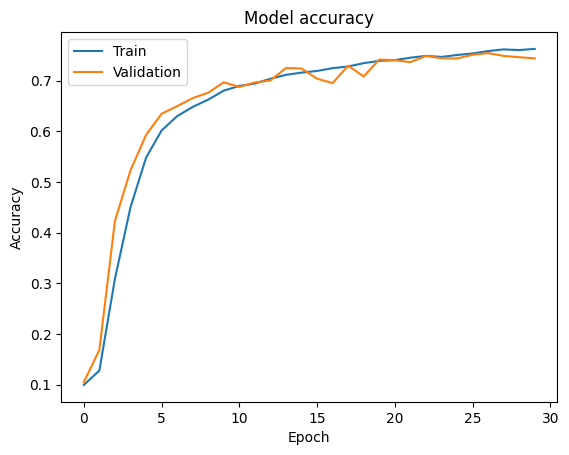

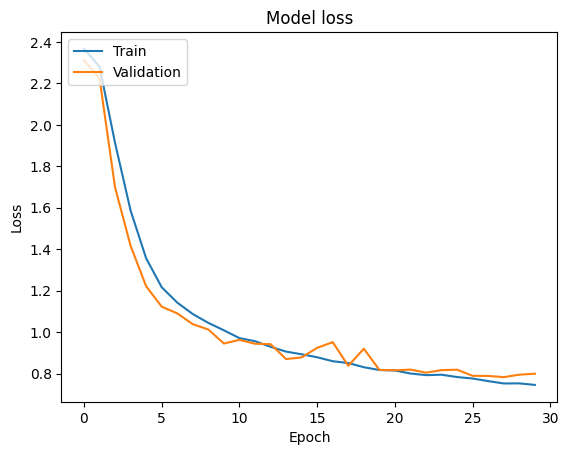

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7532 - loss: 0.7922
Test Accuracy: 0.7502
Test Loss: 0.8089


In [45]:
plot_accuracy_loss(history_2, model_2, X_test, y_test)

**Observations:_______**

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [46]:
y_pred = model_2.predict(X_test)

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [47]:
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

### **Print the classification report and the confusion matrix for the test predictions. Write your observations on the final results.**

In [48]:
def print_report(ytest,ypred):

  # Printing the classification report
  print(classification_report(ytest, ypred))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(ytest, ypred)

  plt.figure(figsize = (8, 5))

  sns.heatmap(cm, annot = True,  fmt = '.0f')

  plt.ylabel('Actual')

  plt.xlabel('Predicted')

  # Display the plot
  plt.show()

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1814
           1       0.75      0.77      0.76      1828
           2       0.82      0.75      0.78      1803
           3       0.67      0.74      0.70      1719
           4       0.86      0.77      0.81      1812
           5       0.71      0.71      0.71      1768
           6       0.78      0.71      0.74      1832
           7       0.74      0.84      0.79      1808
           8       0.63      0.78      0.69      1812
           9       0.79      0.69      0.74      1804

    accuracy                           0.75     18000
   macro avg       0.76      0.75      0.75     18000
weighted avg       0.76      0.75      0.75     18000



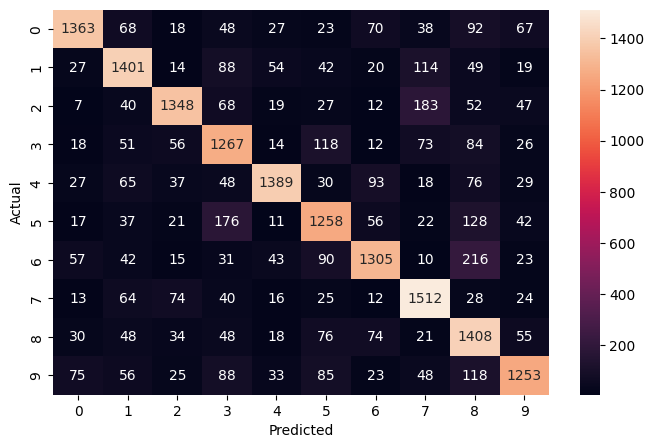

In [49]:
print_report(y_test, y_pred)

**Final Observations:__________**

## **Using Convolutional Neural Networks**

### **Load the dataset again and split the data into the train and the test dataset.**

In [50]:
# Load the data into (X_train, y_train, X_test, y_test, X_val, y_val)

try:
    with h5py.File(file_path, 'r') as hf:
        # Access the data within the .h5 file
        # Example: Assuming your data is stored under keys 'X_train', 'y_train', etc.
        X_train = hf['X_train'][:]
        y_train = hf['y_train'][:]
        X_test = hf['X_test'][:]
        y_test = hf['y_test'][:]

        print("Data loaded successfully!")

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except KeyError as e:
    print(f"Error: Key not found in the .h5 file: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Data loaded successfully!


Check the number of images in the training and the testing dataset.

In [51]:
# Show number of images in each dataset
print("Number of images in X_train:", X_train.shape[0])
print("Number of images in X_test:", X_test.shape[0])

Number of images in X_train: 42000
Number of images in X_test: 18000


**Observation:**

The dataset was reloaded.
There are 42,000 images in train set and 18,000 images in test set.

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to CNNs.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [52]:
print("Shape of first image:", X_train[0].shape)
print("\nArray of pixels for the first image:\n", X_train[0])

Shape of first image: (32, 32)

Array of pixels for the first image:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


Reshape the dataset to be able to pass them to CNNs. Remember that we always have to give a 4D array as input to CNNs

In [53]:
# Reshape the datasets for 4D arrays (CNN excpects color channel)
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

Normalize inputs from 0-255 to 0-1

In [54]:
if X_train.max() > 1:
  X_train = X_train / 255.0

if X_test.max() > 1:
  X_test = X_test / 255.0

In [55]:
# Make sure the data was reshaped and normalized
print("Shape of first image:", X_train[0].shape)
print("\nArray of pixels for the first image:\n", X_train[0])

Shape of first image: (32, 32, 1)

Array of pixels for the first image:
 [[[0.12968785]
  [0.11866706]
  [0.10530196]
  ...
  [0.2801847 ]
  [0.2283153 ]
  [0.16860352]]

 [[0.09893451]
  [0.10020902]
  [0.1175549 ]
  ...
  [0.4432192 ]
  [0.40534863]
  [0.33056822]]

 [[0.10304902]
  [0.08868118]
  [0.15873058]
  ...
  [0.44432473]
  [0.47754902]
  [0.45263842]]

 ...

 [[0.11196157]
  [0.14200786]
  [0.17678471]
  ...
  [0.09465059]
  [0.09840274]
  [0.10219726]]

 [[0.15072627]
  [0.10381687]
  [0.09126157]
  ...
  [0.11023294]
  [0.11556196]
  [0.11790627]]

 [[0.19724864]
  [0.10226392]
  [0.0942702 ]
  ...
  [0.19477727]
  [0.19942354]
  [0.20799099]]]


Print New shape of Training and Test

In [56]:
print("Shape of an image:", X_train[0].shape)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of an image: (32, 32, 1)
Shape of X_train: (42000, 32, 32, 1)
Shape of X_test: (18000, 32, 32, 1)


### **One-hot encode the labels in the target variable y_train and y_test.**

In [57]:
if y_train.ndim == 1:
  y_train = to_categorical(y_train)

if y_test.ndim == 1:
  y_test = to_categorical(y_test)

print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train: (42000, 10)
Shape of y_test: (18000, 10)


**Observation:**

Images in X_train and X_test were reshaped to (32,32,1) to support CNN operations.

y_train and y_test were converted to one-hot with 10 categories.


## **Model Building**

Now that we have done data preprocessing, let's build a CNN model.
Fix the seed for random number generators

In [67]:
# Clear the Keras backend to resolve potential conflicts.
from tensorflow.keras import backend
backend.clear_session()

# Ensuring reproducibility in the executions of the following code
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### **Model Architecture**
- **Write a function** that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_1 and store the output in a new variable.
- Print the summary of the model.
- Fit the model on the training data with a **validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train a CNN model as per the above mentioned architecture.**

In [68]:
# Building the first CNN model:
# The model has 2 convolution layers with leakyRelu
# One maxpool layer
# One hidden dense layer
# and one 10-outputs layer with softmax activation.

def cnn_model_1():
  model = Sequential()
  model.add(Input(shape=(32, 32, 1)))
  model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same'))
  model.add(LeakyReLU(negative_slope=0.1))
  model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
  model.add(LeakyReLU(negative_slope=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(32))
  model.add(LeakyReLU(negative_slope=0.1))
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])
  return model

model_3 = cnn_model_1()

In [69]:
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         262,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,306 (1.02 MB)

 Trainable params: 267,306 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Create a checkpoint file to save the weights of the best epoch (min val_loss)
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model3.weights.h5", save_best_only=True, save_weights_only=True,
                             monitor="val_loss", mode="min")

# Train the model and store each epoch metrics history
history_3 = model_3.fit(X_train, y_train,
                      validation_split=0.2,
                      batch_size=32,
                      verbose=1,
                      callbacks=[checkpoint],
                      epochs=20)

Epoch 1/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4278 - loss: 1.6264 - val_accuracy: 0.8138 - val_loss: 0.6415
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8352 - loss: 0.5665 - val_accuracy: 0.8417 - val_loss: 0.5590
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8669 - loss: 0.4587 - val_accuracy: 0.8551 - val_loss: 0.5129
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8846 - loss: 0.3905 - val_accuracy: 0.8579 - val_loss: 0.5068
Epoch 5/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9005 - loss: 0.3397 - val_accuracy: 0.8564 - val_loss: 0.5192
Epoch 6/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9118 - loss: 0.3003 - val_accuracy: 0.8586 - val_loss: 0.5230
Epoch 7/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9211 - loss: 0.2660 - val_accuracy: 0.8625 - val_loss: 0.5344
Epoch 8/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9316 - loss: 0.2382 - 

### **Plot the Training and Validation Accuracies and Write your observations.**

In [82]:
# Load the weights of the best epoch
model_3.load_weights("model3.weights.h5")

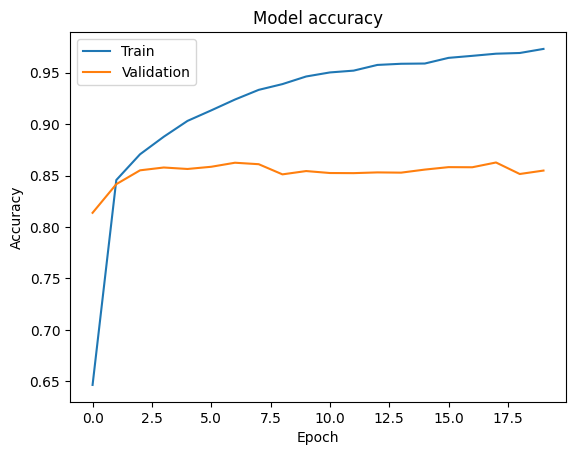

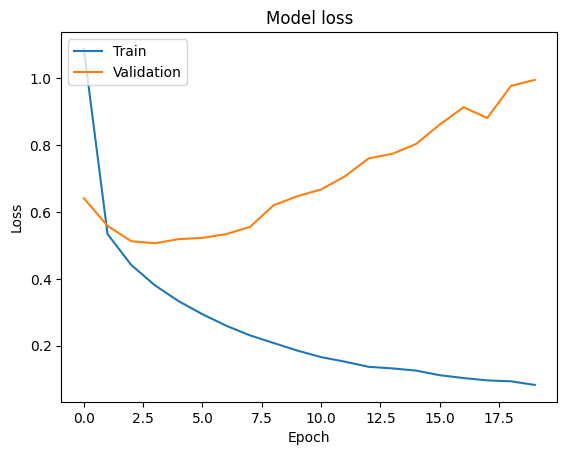

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8651 - loss: 0.4813
Test Accuracy: 0.8615
Test Loss: 0.5007


In [72]:
plot_accuracy_loss(history_3, model_3, X_test, y_test)

**Observations:**

Validation loss reached minimum value at epoch 4 with val accuracy of 0.8579 and val_loss: 0.5068.

After epoch4 the val_loss began to increase and accuracy remained around 0.85, while train loss was decreasing, indicating the model training is loosing stability and starts overfitting.

Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [73]:
# Clear the Keras backend to resolve potential conflicts.
from tensorflow.keras import backend
backend.clear_session()

# Ensuring reproducibility in the executions of the following code
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### **Second Model Architecture**

- Write a function that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **dropout layer with the rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_2 and store the model in a new variable.
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the second CNN model as per the above mentioned architecture.**

In [74]:
# Building the second CNN model:
# The model has 4 convolution layers with leakyRelu
# Two maxpool layers
# Two batchnormalization layers to improve training stability
# dropout layer to reduce overfitting
# One hidden dense layer
# and one 10-outputs layer with softmax activation.

def cnn_model_2():
  model = Sequential()
  model.add(Input(shape=(32, 32, 1)))
  model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same'))
  model.add(LeakyReLU(negative_slope=0.1))
  model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
  model.add(LeakyReLU(negative_slope=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
  model.add(LeakyReLU(negative_slope=0.1))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
  model.add(LeakyReLU(negative_slope=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(32))
  model.add(LeakyReLU(negative_slope=0.1))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])
  return model

model_4 = cnn_model_2()

In [75]:
model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         131,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,362 (642.04 KB)

 Trainable params: 164,170 (641.29 KB)

 Non-trainable params: 192 (768.00 B)

In [76]:
# Create a checkpoint file to save the weights of the best epoch (min val_loss)
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model4.weights.h5", save_best_only=True, save_weights_only=True,
                             monitor="val_loss", mode="min")

# Train the model and store each epoch metrics history
history_4 = model_4.fit(X_train, y_train,
                      validation_split=0.2,
                      batch_size=128,
                      verbose=1,
                      callbacks=[checkpoint],
                      epochs=30)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.3352 - loss: 1.9231 - val_accuracy: 0.3414 - val_loss: 1.8942
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7721 - loss: 0.7392 - val_accuracy: 0.8549 - val_loss: 0.5321
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8191 - loss: 0.5857 - val_accuracy: 0.8519 - val_loss: 0.5108
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8457 - loss: 0.5027 - val_accuracy: 0.8802 - val_loss: 0.4082
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8635 - loss: 0.4525 - val_accuracy: 0.8864 - val_loss: 0.3993
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8714 - loss: 0.4148 - val_accuracy: 0.8802 - val_loss: 0.4143
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8797 - loss: 0.3933 - val_accuracy: 0.8829 - val_loss: 0.4029
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8889 - loss: 0.3609 - val_accuracy: 

### **Plot the Training and Validation accuracies and write your observations.**

In [77]:
# Load the weights of the best epoch
model_4.load_weights("model4.weights.h5")

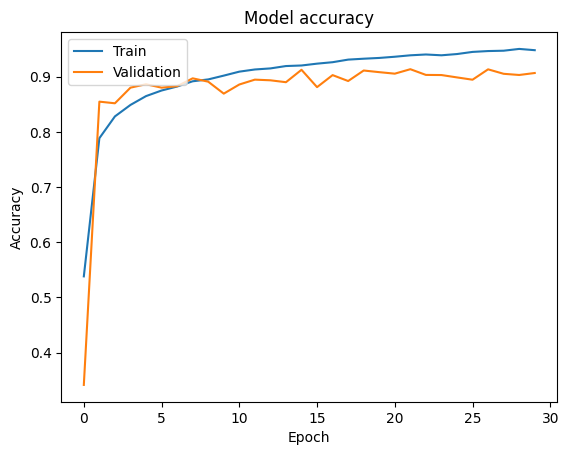

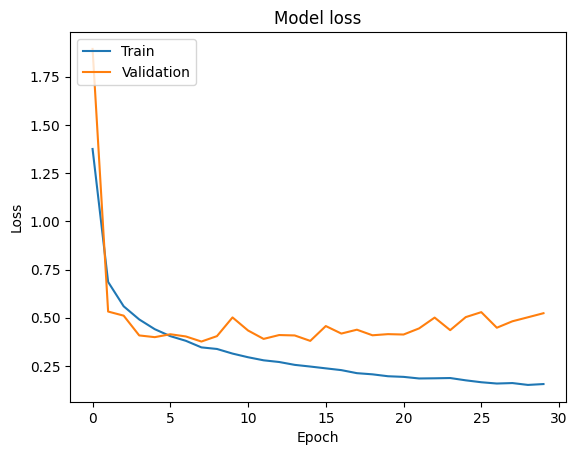

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9010 - loss: 0.3631
Test Accuracy: 0.8969
Test Loss: 0.3849


In [78]:
plot_accuracy_loss(history_4, model_4, X_test, y_test)

**Observations:**

* Validation loss reached minimum value at epoch 8 with validation accuracy of 0.8971 and val_loss: 0.3765.
* Second CNN network is deeper than first CNN network but with less trained parameters, due to smaller dense layer, so training is faster.
* Second CNN network is more accurate than first CNN network: test accuracy of 0.8969 vs 0.8615 and test loss of 0.3849 vs. 0.5.
* Training the second CNN is more stable due to batch-normalization and less overfit due to dropout.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

### **Make predictions on the test data using the second model.**

In [79]:
y_pred = model_4.predict(X_test)

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector, but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [80]:
# Convert results to 1-digit label from the one-hot vector

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

### **Write your final observations on the performance of the model on the test data.**

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1814
           1       0.91      0.89      0.90      1828
           2       0.90      0.92      0.91      1803
           3       0.84      0.89      0.86      1719
           4       0.90      0.92      0.91      1812
           5       0.86      0.91      0.89      1768
           6       0.88      0.88      0.88      1832
           7       0.94      0.90      0.92      1808
           8       0.89      0.87      0.88      1812
           9       0.92      0.86      0.89      1804

    accuracy                           0.90     18000
   macro avg       0.90      0.90      0.90     18000
weighted avg       0.90      0.90      0.90     18000



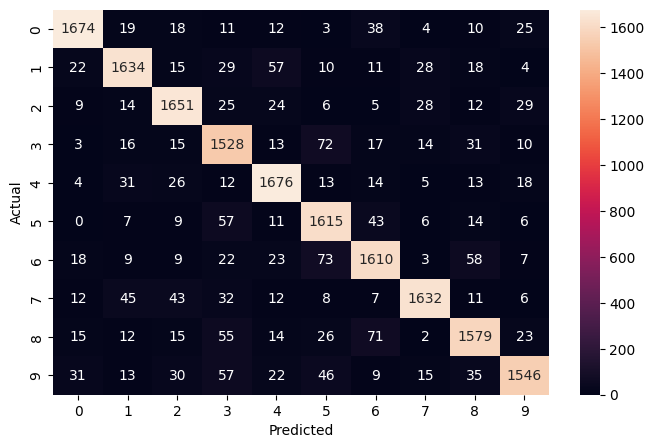

In [81]:
print_report(y_test, y_pred)

## Show some correct and misclassified images

In [94]:
y_pred

array([8, 7, 2, ..., 7, 3, 2])

In [95]:
y_test

array([1, 7, 2, ..., 7, 9, 2])

In [96]:
y_pred != y_test


array([ True, False, False, ..., False,  True, False])

In [101]:
# Build X_test_false and y_test_false that contain the misclassified samples

X_test_false = X_test[y_pred != y_test]
y_pred_false = y_pred[y_pred != y_test]
y_test_false = y_test[y_pred != y_test]

In [98]:
# Build X_test_true and y_test_true that contain the correct classified samples

X_test_true = X_test[y_pred == y_test]
y_pred_true = y_pred[y_pred == y_test]

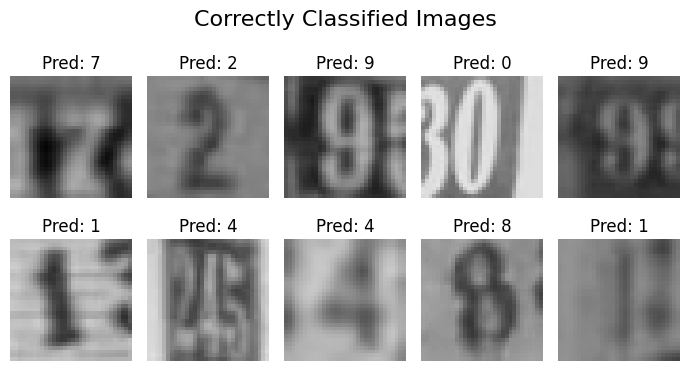

In [106]:
# Showing first 10 correct classified images

cols = 5
rows = 2

fig = plt.figure(figsize = (7, 4))

for i in range(cols):

    for j in range(rows):

        indx = i * rows + j

        ax = fig.add_subplot(rows, cols, indx + 1)

        ax.imshow(X_test_true[indx, :], cmap='gray', vmin=0, vmax=1)

        ax.set_title(f"Pred: {y_pred_true[indx]}")

        ax.axis('off')

fig.suptitle("Correctly Classified Images", fontsize=16)
plt.tight_layout()
plt.show()

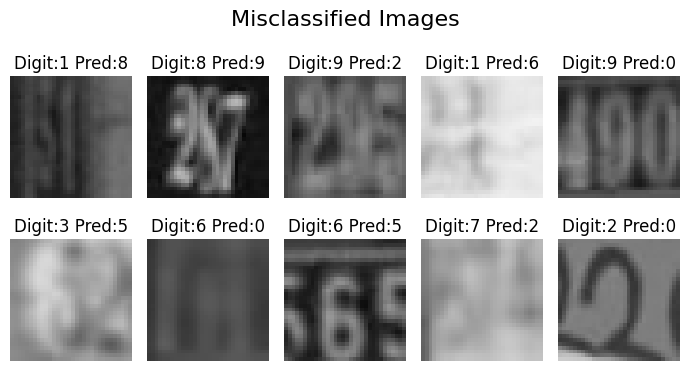

In [107]:
# Showing first 10 misclassified images

cols = 5
rows = 2

fig = plt.figure(figsize = (7, 4))

for i in range(cols):

    for j in range(rows):

        indx = i * rows + j

        ax = fig.add_subplot(rows, cols, indx + 1)

        ax.imshow(X_test_false[indx, :], cmap='gray', vmin=0, vmax=1)

        ax.set_title(f"Digit:{y_test_false[indx]} Pred:{y_pred_false[indx]}")

        ax.axis('off')

fig.suptitle("Misclassified Images", fontsize=16)
plt.tight_layout()
plt.show()

##**Final Observations:**

summary of results:

| Model  | Val Acc | Val Loss | Test Acc | Test Loss | Num of Params |
|--------|---------|----------|----------|-----------|-------------------|
| ANN 1  | 0.6594  | 1.0976   | 0.6675   | 1.0909    | 68,010            |
| ANN 2  | 0.7492  | 0.7828   | 0.7502   | 0.8089    | 310,250           |
| CNN 1  | 0.8579  | 0.5068   | 0.8615   | 0.5007    | 267,306           |
| CNN 2  | 0.8971  | 0.3765   | 0.8969   | 0.3849    | 164,362           |

* Second CNN network is deeper than first CNN network but with less trained parameters, due to smaller dense layer.
* Second CNN network, although with less parameters, is more accurate than first CNN network.
* Deeper networks gives better results than similar networks with less layers (shallow).
* CNN networks use less parameters than deep ANN networks but give better results on image data.
* Training the second CNN is more stable due to batch-normalization and less overfit due to dropout.
* Among the 4 models, CNN model 2 gives the best results.

### Some techniques to further improve the results:
* Optimize hyperparameters.
* Use deeper architecture. Add more CNN layers and filters.
* Use pre-trained state-of-the-art CNN networks (e.g: VGG, ResNet) and train the classifier dense layer.
* Data augmentation - add artificial data.
* Boosting - train several weak classifiers on misclassified samples and do majority vote for final classification.